In [44]:
!pip install -Uqq pyts fastbook binance-connector

In [45]:
# Import necessary libraries
import datetime as dt
import os
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pandas as pd
import pywt
import pywt.data
import re
from pyts.image import GramianAngularField
from PIL import Image as im
from binance.spot import Spot
%matplotlib inline 

import fastbook
fastbook.setup_book()
from fastbook import *
import matplotlib.image

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [46]:
#pywt.wavelist('sym')

In [ ]:
SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
INPUT_SIZE = 30
RAW_INPUT_SIZE = 100
THRESHOLD = 0.97
TRADING_PERCENT = 0.1
INITIAL_USD_BALANCE = 1000
STOP_PROFIT = 0.004
STOP_LOSS = 0.004
ORDER_LIFE = 5

In [ ]:
rest_client = Spot()
def prepare_dataset():
    startTime = None
    endTime = None
    data = rest_client.klines(SYMBOL, INTERVAL, limit=500)


In [47]:
wavelet_type = 'sym15'
w = pywt.Wavelet(wavelet_type)
def denoise(data):
    if len(data) > 0:
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        coeffs = pywt.wavedec(data, wavelet_type, level=maxlev)
        coeffs[-1] = np.zeros_like(coeffs[-1])
        datarec = pywt.waverec(coeffs, wavelet_type)
        return datarec
    else:
        return data

In [48]:
BTC = pd.read_csv("../input/bitcoin-btcusdt/Bitcoin_BTCUSDT.csv")
df = BTC.iloc[-50000:]

In [49]:
DS_LENGTH = len(df.close)

<AxesSubplot:>

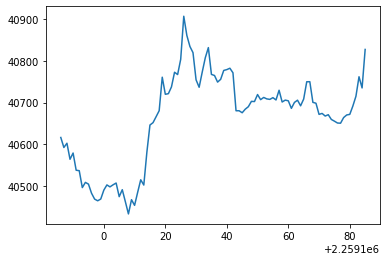

In [50]:
df_input = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    df_input[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].close
    
df_input[120].plot.line()

<AxesSubplot:>

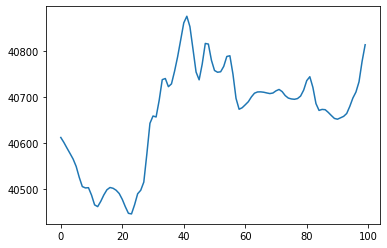

In [51]:
df_denoised_input = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    df_denoised_input[i] = denoise(df_input[i])
    
pd.Series(df_denoised_input[120]).plot.line()

In [52]:
gaf_transformer = GramianAngularField(method='difference', image_size=INPUT_SIZE)
df_gaf_input = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if len(df_denoised_input[i]) > 0:
        df_gaf_input[i] = gaf_transformer.fit_transform(df_denoised_input[i][-INPUT_SIZE:].reshape(1, -1))




In [53]:
df_with_input = df.copy()
df_with_input['input'] = df_gaf_input
df_with_input = df_with_input.iloc[100:]


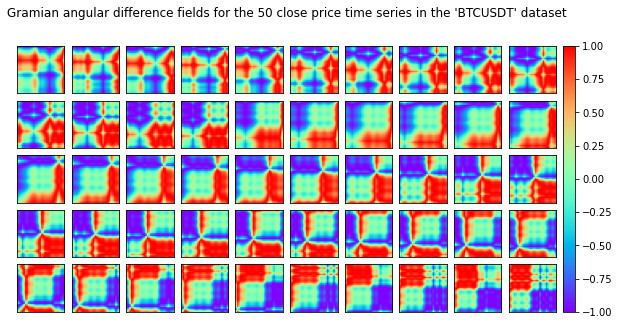

In [54]:
fig = plt.figure(figsize=(10, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    image_item = ax.imshow(df_with_input['input'].to_numpy()[i+20].squeeze(), cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(image_item, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("Gramian angular difference fields for the 50 close price time series in the "
             "'BTCUSDT' dataset")
plt.show()

In [55]:

def calc_label(dataset, position):
    price = dataset['close'].to_numpy()[position]
    stop_loss = STOP_LOSS * price
    stop_profit = STOP_PROFIT * price
    label = "wait"
    bearish_stop_loss = price + stop_loss
    bearish_stop_profit = price - stop_profit
    bullish_stop_loss = price - stop_loss
    bullish_stop_profit = price + stop_profit
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if low_price > bullish_stop_loss:
            if max_price >= bullish_stop_profit:
                label = "buy"
                break
        else:
            break
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if max_price < bearish_stop_loss:
            if low_price <= bearish_stop_profit:
                label = "sell"
                break
        else:
            break
    return label
        
       

    

In [56]:
L = len(df_with_input['close'])
df_labels = [None]*L
for i in range(0, L-ORDER_LIFE):
    df_labels[i] = calc_label(df_with_input, i)

df_labeled = df_with_input.copy()
df_labeled['label'] = df_labels
df_labeled = df_labeled.iloc[:-ORDER_LIFE]

In [57]:
def oversample():
    class_3,class_2,class_1 = df_labeled.label.value_counts()
    print(class_3,class_2,class_1)
    c3 = df_labeled[df_labeled['label'] == "wait"]
    c2 = df_labeled[df_labeled['label'] == "sell"]
    c1 = df_labeled[df_labeled['label'] == "buy"]
    c1_frac = class_3 / class_1
    c2_frac = class_3 / class_2
    df_1 = c1.sample(frac=c1_frac,replace=True)
    df_2 = c2.sample(frac=c2_frac,replace=True)
    return pd.concat([df_1,df_2,c3],axis=0).sample(frac=1).reset_index(drop=True)

In [ ]:
def oversampleCopied(df):
    classes = df.label.value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [58]:
def downsample():
    class_3,class_2,class_1 = df_labeled.label.value_counts()
    print(class_3,class_2,class_1)
    c3 = df_labeled[df_labeled['label'] == "wait"]
    c2 = df_labeled[df_labeled['label'] == "sell"]
    c1 = df_labeled[df_labeled['label'] == "buy"]
    df_3 = c3.sample(class_1)
    return pd.concat([df_3,c1,c2],axis=0).sample(frac=1).reset_index(drop=True)

In [59]:
df_train = oversample()

42366 3806 3723


In [60]:
images_path = '/kaggle/working/images/'
if not os.path.exists(images_path):
   os.makedirs(images_path)

In [61]:
files = get_image_files(images_path)
for f in files:
    os.remove(f)

In [62]:
L = len(df_train['close'])
for i in range(0, L):
    data = df_train['input'].to_numpy()[i].squeeze()
    label = df_train['label'].to_numpy()[i]
    matplotlib.image.imsave(images_path + label + '_' + str(i) + '.png', data)

In [63]:
files = get_image_files(images_path)

In [64]:
files

(#127119) [Path('/kaggle/working/images/buy_104062.png'),Path('/kaggle/working/images/buy_107083.png'),Path('/kaggle/working/images/wait_2469.png'),Path('/kaggle/working/images/buy_35114.png'),Path('/kaggle/working/images/sell_122223.png'),Path('/kaggle/working/images/sell_49981.png'),Path('/kaggle/working/images/sell_5276.png'),Path('/kaggle/working/images/buy_89335.png'),Path('/kaggle/working/images/wait_123705.png'),Path('/kaggle/working/images/buy_3740.png')...]

In [65]:
pat = r'^(.*)_\d+.png'

In [66]:

dls = ImageDataLoaders.from_name_re(images_path, files, pat)

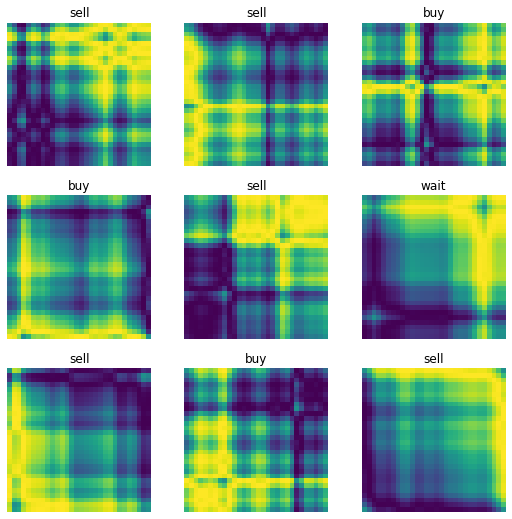

In [67]:
dls.show_batch()

In [68]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(valley=0.0006918309954926372)

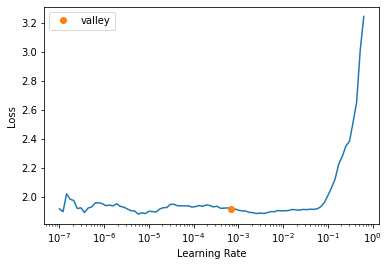

In [69]:
#learn.lr_find()

In [73]:
learn.fine_tune(2, 0.0006918309954926372)

epoch,train_loss,valid_loss,error_rate,time
0,1.101667,1.057789,0.555993,04:13


epoch,train_loss,valid_loss,error_rate,time
0,0.687028,0.550177,0.226999,04:34
1,0.431335,0.297045,0.112693,04:34


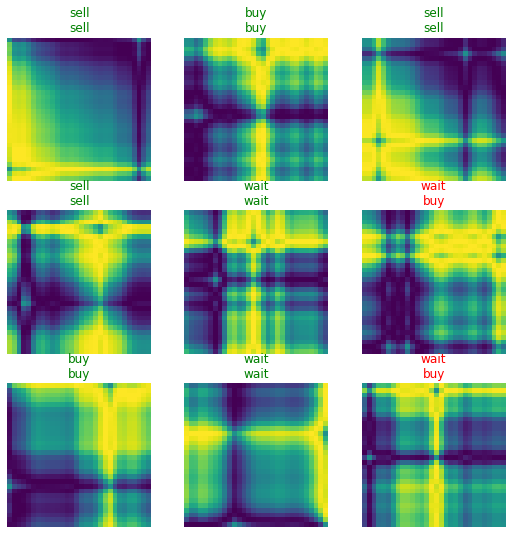

In [74]:
#learn.show_results()

In [72]:
#learn.predict(files[0])

In [ ]:
learn.export(fname='/kaggle/working/model.pkl')
